## Finding adversarial examples using stochastic optimization

While the initial method of adversarial example generation presented by Goodfellow capitalized on the gradient signs, it is also possible to generate adversarial examples by optimizing a noise pattern to disrupt the softmax classification. In this paradigm you train a deep learning network to learn what noise patterns lead to misclassifications, and can be used for targeted attacks. 

The concepts used in this notebook were from: https://github.com/Hvass-Labs/TensorFlow-Tutorials

In [1]:
#Importing necessary libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import inception

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


## Importing CNN model

In [2]:
# I have a pretrained CNN model, so I built the architecture in Keras. Keras compiles down to Tensorflow
# so it's possible to use TF as a backend, like I will do below

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# A sequential model with dropout layers
model = Sequential() 
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [3]:
#Installing MNIST data

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# Just checking to see that the model that I loaded up actually works. 96% is pretty bad but my computer is slow
# so I just ran a CNN for one epoch to get this accuracy. Definitely something to be fixed in future iterations.

from keras.metrics import categorical_accuracy as accuracy
labels = tf.placeholder(tf.float32, shape=(None, 10))

with tf.Session() as sess:
    
    #sess.run(tf.global_variables_initializer())
    
    model.load_weights('cnn_weights3.h5')
    
    xs = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    ys = model(xs)

    acc_value = accuracy(labels, ys)

    res = (acc_value.eval(feed_dict={xs: x_test,
                                    labels: y_test,
                                    K.learning_phase(): 0}))
    print("The original accuracy of the MNIST dataset: {}".format(np.mean(res)))

The original accuracy of the MNIST dataset: 0.960099995136261


## 500px challenge

So this challenge is to generate adversarial examples that fool a classifier to misclassify a 2 into a 6.

In [204]:
ind = np.where(np.argmax(y_train, axis=1) == 2)
class_two_train_x = x_train[ind]
class_two_train_y = y_train[ind]

ind = np.where(np.argmax(y_test, axis=1) == 2)
class_two_test_x = x_test[ind]
class_two_test_y = y_test[ind]

In [5]:
#This function is used to initialize only uninitilized variables. This is useful because otherwise
#TF would write over my loaded CNN model causing it to classify with completely random accuracy. 
"""BORROWED CODE START"""
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    #print[str(i.name) for i in not_initialized_vars] # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
"""BORROWED CODE END"""

In [230]:
#Some basic paramters of the training model
img_size = 28
num_channels = 1
batch_size = 64
epochs = 12
num_batches = int(class_two_train_x.shape[0] / batch_size)

"""BORROWED CODE START"""
#Creating a variable collection called adversary_variables
#Only these will be optimized in the training process
ADVERSARY_VARIABLES = 'adversary_variables'
collections = [tf.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

#A place holder for the image data
x_image = tf.placeholder(tf.float32, (None, img_size, img_size, num_channels))

#What the network will modify to misclassify examples
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                  name='x_noise', collections=collections)
"""BORROWED CODE END"""

In [213]:
def gen_adv(noise_limit, target_cls=6, noise_l2_weight=0.2):
    
    #Clipping the noise so that it doesn't perturb the image too much
    x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise,
                                                   -noise_limit,
                                                   noise_limit))
    
    #adding the noise to the imaeg data
    x_noisy_image = x_image + x_noise    
    #Clipping it again so that none of the values fall outisde the range of the original MNIST data
    x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)
    
    #Getting a list of variables to be tuned
    adversary_variables = tf.get_collection('adversary_variables')
    #print([var.name for var in adversary_variables])
    
    """
    Creating model output and input
    """
    #ys is the output of the model (a logits output)
    ys = model(x_noisy_image)
    #labels are the "true" output. In this example, we will be putting in misclassification
    #as the "true" output to make the network learn how output that prediction.
    labels = tf.placeholder(tf.float32, shape=(None, 10))
    
    """
    Our loss function has two parts:
    loss is the regular corss entropy loss of the prediction with the ground truth.
    l2_loss_noise is a regularization tool to ensure that the noise values are so large
    that the noisy image no longer resembles the initial image. 
    """
    """BORROWED CODE START"""
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=ys, labels=labels))
    l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)
    
    loss_adversary = loss + l2_loss_noise
    #optimize only for the adversary variables. 
    optimizer_adversary = tf.train.AdamOptimizer(learning_rate=0.01).\
        minimize(loss_adversary, var_list=adversary_variables)
    """BORROWED CODE END"""
        
    #generate a matrix of target classes to use as labels for optimization
    target_labels = np.zeros(10)
    target_labels[target_cls] = 1
    target_labels = np.repeat([target_labels], batch_size, axis=0)

    with tf.Session() as sess:
        
        #Load CNN weights, initialize TF variables
        model.load_weights('cnn_weights3.h5')
        sess.run(tf.variables_initializer([x_noise]))
        initialize_uninitialized(sess)
    
        for e in range(25):
            
            for i in range(num_batches):
                
                _, loss = sess.run([optimizer_adversary, loss_adversary], feed_dict={
                    x_image:class_two_train_x[i*batch_size: (i+1)*batch_size],
                    labels:target_labels,
                    K.learning_phase():0
                })
                
                sess.run(x_noise_clip)
                
            print('finished optimizing epoch {}'.format(e))
            pred = sess.run(ys, feed_dict={
                x_image:class_two_test_x,
                K.learning_phase():0
            })
            print('percentage of correctly classified images:')
            print(np.sum(np.argmax(pred, axis=1) == 2) / (class_two_test_x.shape[0] + 0.0))
            print('percentage of images classified as target class:')
            print(np.sum(np.argmax(pred, axis=1) == target_cls) / (class_two_test_x.shape[0] + 0.0))
            print('===================')
            
        return x_noise.eval()

In [214]:
noise = gen_adv(noise_limit=0.35, target_cls=6, noise_l2_weight=0.001)

finished optimizing epoch 0
percentage of correctly classified images:
0.233527131783
percentage of images classified as target class:
0.698643410853
finished optimizing epoch 1
percentage of correctly classified images:
0.218023255814
percentage of images classified as target class:
0.717054263566
finished optimizing epoch 2
percentage of correctly classified images:
0.217054263566
percentage of images classified as target class:
0.720930232558
finished optimizing epoch 3
percentage of correctly classified images:
0.217054263566
percentage of images classified as target class:
0.720930232558
finished optimizing epoch 4
percentage of correctly classified images:
0.217054263566
percentage of images classified as target class:
0.720930232558
finished optimizing epoch 5
percentage of correctly classified images:
0.208333333333
percentage of images classified as target class:
0.729651162791
finished optimizing epoch 6
percentage of correctly classified images:
0.208333333333
percentage of 

In [179]:
np.max(noise)

0.34999999

## Testing the adversarial noise

In [180]:
#adding the noise to the test images
noisy_test = []

for i in x_test[:100]:
    noisy_test.append(i + noise.reshape((28, 28, 1)) * 100)

In [215]:
np.max(noise)

0.34999999

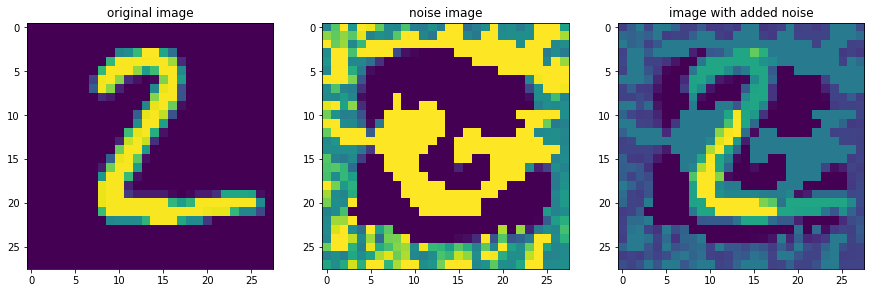

In [229]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(class_two_test_x[0].squeeze())
plt.title('original image')

plt.subplot(132)
plt.imshow(noise.squeeze())
plt.title('noise image')

plt.subplot(133)
plt.imshow(class_two_test_x[0].squeeze() + noise.squeeze())
plt.title('image with added noise')

## Generating the chart for the challenge

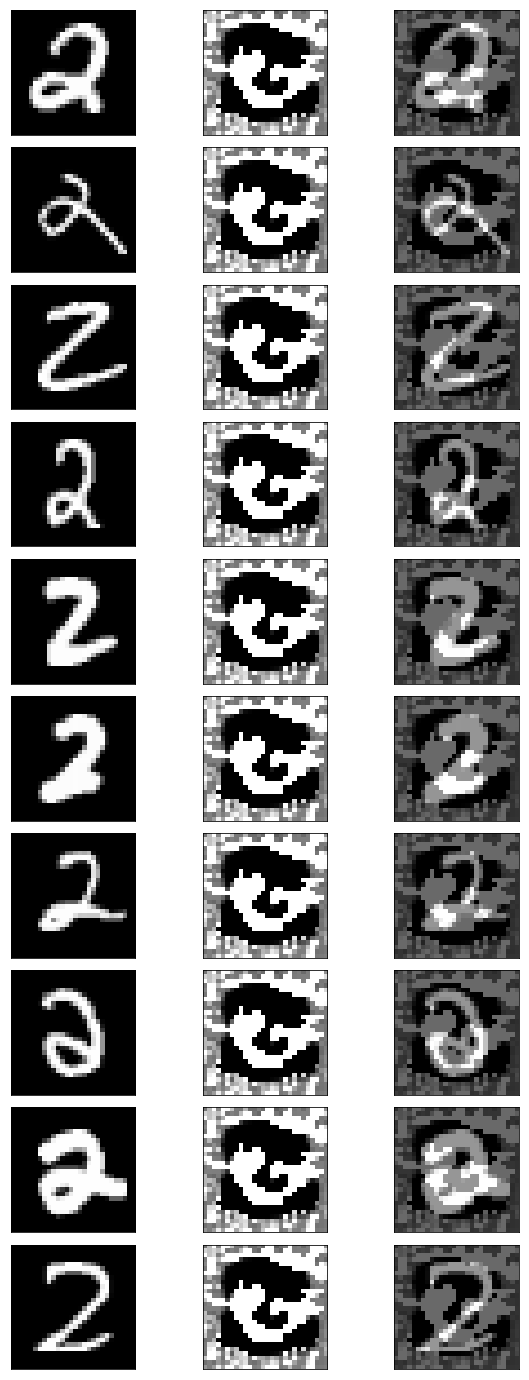

In [219]:
# Creating a figure of subplots
fig, axes = plt.subplots(10, 3, figsize=(10, 25))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes):
        
    image = class_two_test_x[i + 10]

    image = image.reshape((28, 28))

    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(noise.squeeze(), cmap='gray')
    ax[2].imshow(image + noise.squeeze(), cmap='gray')
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

# Show cells
plt.show()

## Running prediction function for images before added noise

In [226]:
samples = class_two_test_x[:10]

with tf.Session() as sess:
    
    xs = tf.placeholder(tf.float32, (None, 28, 28, 1))
    ys = model(xs)
    model.load_weights('cnn_weights3.h5')
    
    pred = sess.run(ys, feed_dict={
        xs: samples,
        K.learning_phase(): 0
    })

In [225]:
np.argmax(pred, axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Running prediction function for images before adding noise

In [ ]:
samples = class_two_test_x[:10]

with tf.Session() as sess:
    
    xs = tf.placeholder(tf.float32, (None, 28, 28, 1))
    ys = model(xs)
    model.load_weights('cnn_weights3.h5')
    
    pred = sess.run(ys, feed_dict={
        xs: samples,
        K.learning_phase(): 0
    })

In [227]:
np.argmax(pred, axis=1)

array([6, 6, 6, 6, 6, 6, 6, 2, 6, 6])